Conda env: `aops_tenflow`

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.utils_for_classification import classification_evaluation
tf.get_logger().setLevel('ERROR')

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

epochs = 8
learning_rate = 1e-6


c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_tenflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

## Load Dataset

In [2]:
train_ds_ = tf.keras.utils.text_dataset_from_directory('../data/classification/train', batch_size=batch_size)
train_ds = train_ds_.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory('../data/classification/test', batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory('../data/classification/val', batch_size=batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = train_ds_.class_names

# Map string labels to integer indices
label_processor = tf.keras.layers.StringLookup(
    vocabulary=['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'],
    mask_token=None  # Treats unknown tokens as missing values
)

train_labels = train_ds.map(lambda text, label: label_processor(label))
test_labels = test_ds.map(lambda text, label: label_processor(label))
val_labels = val_ds.map(lambda text, label: label_processor(label))


Found 2524 files belonging to 4 classes.
Found 703 files belonging to 4 classes.
Found 283 files belonging to 4 classes.


## Modeling

In [3]:
class ClassifierModel:
    def __init__(self, tfhub_preprocess, tfhub_encoder, seq_length=512):
        self.tfhub_preprocess = tfhub_preprocess
        self.tfhub_encoder = tfhub_encoder
        self.seq_length = seq_length
        self.model = self.__build_model()
        self.history = None
        
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        self.learning_rate = None
        self.optimizer_type = None
        self.loss = None
        self.metrics = None
        self.optimizer = None
        self.__is_compiled = False
        
        self.__is_trained = False

        self.training_time = None

    def __build_model(self):
        # Step 1: Define text input layer
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        
        # Step 2: Tokenize batches of text inputs
        bert_preprocess = hub.load(self.tfhub_preprocess)
        tokenize = hub.KerasLayer(bert_preprocess.tokenize)
        tokenized_input = tokenize(text_input)
        
        # Step 3: Pack input sequences for the Transformer encoder
        bert_pack_inputs = hub.KerasLayer(
            bert_preprocess.bert_pack_inputs,
            arguments=dict(seq_length=self.seq_length))
        encoder_inputs = bert_pack_inputs([tokenized_input])
        
        # Load BERT encoder
        encoder = hub.KerasLayer(self.tfhub_encoder, trainable=True, name='BERT_encoder')
        # Pass encoder inputs through BERT encoder
        outputs = encoder(encoder_inputs)

        # Define classifier layers
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(512, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
        
        return tf.keras.Model(text_input, net)
    
    def compile_model(
        self, 
        train_ds, 
        validation_data,
        epochs, 
        learning_rate, 
        optimizer_type='adamw', 
        loss=tf.keras.losses.sparse_categorical_crossentropy,   # Assuming you have integer labels
        metrics=['accuracy']):
        
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.loss = loss
        self.metrics = metrics
        
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=int(0.1*num_train_steps),
            optimizer_type=self.optimizer_type
        )
        self.optimizer= optimizer
        
        # Comple model
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.__is_compiled = True
    
    def train(self):
        if self.__is_compiled is False: raise Warning("Model is not compiled yet")
        
        print(f"Model       : {self.tfhub_encoder}")
        print(f"Preprocessor: {self.tfhub_preprocess}\n")

        print(f"epochs       : {self.epochs}")
        print(f"learning_rate: {self.learning_rate}\n")

        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
            )
        end = perf_counter()
        print(f"\nTotal training time: {end-start:.2f}s")
        
        self.training_time = end-start
        self.history = history.history
        self.__is_trained = True
        return history
    
    def evaluate_test(self, test_ds):
        if self.__is_trained is False: raise Warning("Model is not trained yet")

        self.model.evaluate(test_ds)

        X_test, y_actual_string, y_actual_mapped = [], [], []
        for text_, label_ in test_ds:
            text_, label_ = list(text_.numpy()), list(label_.numpy())
            y_actual_mapped += label_
            for i, item in enumerate(label_):
                if item == 0:
                    label_[i] = class_names[0]
                elif item == 1:
                    label_[i] = class_names[1]
                elif item == 2:
                    label_[i] = class_names[2]
                elif item == 3:
                    label_[i] = class_names[3]
                else: raise ValueError("Tidak mungkin error!")
            X_test += text_
            y_actual_string += label_

        y_actual_mapped = tf.constant(y_actual_mapped)
        y_pred = self.predict(X_test)
        y_pred_listed = list(y_pred)
        for i, item in enumerate(y_pred_listed):
            temp = list(item)
            if temp.index(max(temp)) == 0: y_pred_listed[i] = class_names[0]
            elif temp.index(max(temp)) == 1: y_pred_listed[i] = class_names[1]
            elif temp.index(max(temp)) == 2: y_pred_listed[i] = class_names[2]
            elif temp.index(max(temp)) == 3: y_pred_listed[i] = class_names[3]
            else: raise ValueError("Never error!")

        print()
        heatmap, report = classification_evaluation(y_actual_string, y_pred_listed)
        loss_test = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_actual_mapped, y_pred))
        print(f"loss: {loss_test}")
        heatmap.plot()
        plt.show()
        
        return report, loss_test, heatmap

    def plot_training_history_over_time(self, figsize=(14, 4)):
        if self.history is None: raise Warning("Nothing to plot because model is not trained yet")
        
        print(self.history.keys())
        print("Training history over time")
        
        acc = self.history['accuracy']
        val_acc = self.history['val_accuracy']
        loss = self.history['loss']
        val_loss = self.history['val_loss']
        epochs = range(1, len(acc) + 1)
        
        figure, ax = plt.subplots(1, 2, figsize=figsize, layout="constrained")

        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')  # r is for "solid red line"
        plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'r', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

    def predict(self, text: list):
        """
            text: should parsed like this --> ["Your text here!"]
        """
        return self.model.predict(tf.constant(text))

optimizer_type = 'adamw'
loss = tf.keras.losses.sparse_categorical_crossentropy
metrics = ['accuracy']


In [4]:
tfhub_map = {
    "BERT-EN-CASED-L-12-H-768-A-12" : "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4",
    "BERT-EN-UNCASED-L-2-H-512-A-8": "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-512-a-8/2",

    "BERT-EN-CASED-PREPROCESSOR"  : "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3",
    "BERT-EN-UNCASED-PREPROCESSOR": "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3",
}

bert_encoder = "BERT-EN-UNCASED-L-2-H-512-A-8"
preprocessor = "BERT-EN-UNCASED-PREPROCESSOR"
classifier_model_1 = ClassifierModel(tfhub_map[preprocessor], tfhub_map[bert_encoder])
classifier_model_1.compile_model(train_ds=train_ds,
                                 validation_data=val_ds,
                                 epochs=epochs, 
                                 learning_rate=learning_rate, 
                                 optimizer_type=optimizer_type, 
                                 loss=loss, 
                                 metrics=metrics)


In [5]:
classifier_model_1.train()
training_time = classifier_model_1.training_time


Model       : https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-512-a-8/2
Preprocessor: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3

epochs       : 8
learning_rate: 1e-06

Epoch 1/8
158/158 [==============================] - 17s 83ms/step - loss: 1.4101 - accuracy: 0.2758 - val_loss: 1.3424 - val_accuracy: 0.3322
Epoch 2/8
158/158 [==============================] - 12s 78ms/step - loss: 1.3606 - accuracy: 0.3162 - val_loss: 1.2815 - val_accuracy: 0.4629
Epoch 3/8
158/158 [==============================] - 12s 78ms/step - loss: 1.3195 - accuracy: 0.3712 - val_loss: 1.2293 - val_accuracy: 0.5972
Epoch 4/8
158/158 [==============================] - 12s 78ms/step - loss: 1.2723 - accuracy: 0.4469 - val_loss: 1.1772 - val_accuracy: 0.6608
Epoch 5/8
158/158 [==============================] - 12s 78ms/step - loss: 1.2377 - accuracy: 0.5012 - val_loss: 1.1389 - val_accuracy: 0.6820
Epoch 6/8
158/

22/22 [==============================] - 2s 100ms/step

               precision    recall  f1-score   support

      Algebra     0.5556    0.8333    0.6667       174
Combinatorics     0.8641    0.5633    0.6820       158
     Geometry     0.7906    0.9391    0.8585       197
Number Theory     0.7714    0.4655    0.5806       174

     accuracy                         0.7112       703
    macro avg     0.7454    0.7003    0.6969       703
 weighted avg     0.7442    0.7112    0.7026       703

loss: 1.098677396774292


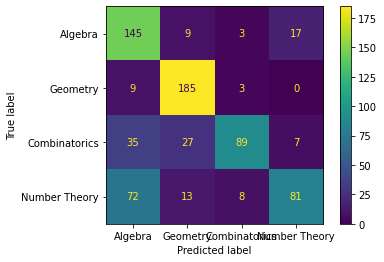

In [6]:
report, loss, heatmap = classifier_model_1.evaluate_test(test_ds)
accuracy, precision, recall, f1 = report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']


In [7]:
print(f"xx,classification,{bert_encoder},{batch_size},{epochs},{learning_rate},{optimizer_type},tf.keras.losses.sparse_categorical_crossentropy,{loss},{accuracy},{precision},{recall},{f1},{training_time}")


xx,classification,BERT-EN-UNCASED-L-2-H-512-A-8,16,8,1e-06,adamw,tf.keras.losses.sparse_categorical_crossentropy,1.098677396774292,0.7112375533428165,0.7441925649897034,0.7112375533428165,0.7025681035603188,103.0834864


In [8]:
# classifier_model_1.plot_training_history_over_time(figsize=(14, 4))


In [9]:
# # Save model
# temp_path1 = "saved_models/classification/BERT-CASED-L-12-H-768-A-12"
# classifier_model_1.model.save(temp_path1)


In [1]:
from sklearn.metrics import log_loss
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow import constant
from tensorflow import reduce_mean


y_true = constant([0, 1, 2, 0, 1])

y_pred_proba = constant([
    [0.7, 0.2, 0.1],
    [0.1, 0.6, 0.3],
    [0.2, 0.3, 0.5],
    [0.8, 0.1, 0.1],
    [0.3, 0.5, 0.2]
])

loss1 = log_loss(y_true, y_pred_proba)
loss2 = reduce_mean(sparse_categorical_crossentropy(y_true, y_pred_proba)).numpy()


print("Log Loss1:", loss1)
print("Log Loss2:", loss2)


Log Loss1: 0.49538768231868746
Log Loss2: 0.4953877
